# Building a model to predict just HDF

In [110]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.discriminant_analysis import StandardScaler

from pyprojroot import here
import wandb

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Download the latest data
if False:
    run = wandb.init()
    artifact = run.use_artifact('w207-predictive-maintenance/predictive-maintenance/ai4i2020:v0', type='dataset')
    artifact_dir = artifact.download(here('data'))

wandb: Currently logged in as: paul-a-terrasi (tj2) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb:   14 of 14 files downloaded.  


In [4]:
X_train = pd.read_csv(here('data/processed/X_train.csv'))
print(f"X_train {X_train.shape}:")
print(X_train.describe())
print()
Y_train = pd.read_csv(here('data/processed/Y_train.csv'))
print(f"Y_train {Y_train.shape}:")
print(Y_train.describe())

X_val = pd.read_csv(here('data/processed/X_val.csv'))
print(f"X_val {X_val.shape}:")
print(X_val.describe())
print()
Y_val = pd.read_csv(here('data/processed/Y_val.csv'))
print(f"Y_val {Y_val.shape}:")
print(Y_val.describe())

X_train (7499, 6):
       quality_variation  Air temperature  Process temperature  \
count        7499.000000      7499.000000          7499.000000   
mean            0.498066       300.002854           310.005347   
std             0.669290         2.005323             1.484268   
min             0.000000       295.300000           305.700000   
25%             0.000000       298.300000           308.800000   
50%             0.000000       300.100000           310.100000   
75%             1.000000       301.500000           311.100000   
max             2.000000       304.500000           313.800000   

       Rotational speed       Torque    Tool wear  
count       7499.000000  7499.000000  7499.000000  
mean        1537.916789    40.039725   108.030004  
std          180.646539     9.970724    63.685869  
min         1181.000000     3.800000     0.000000  
25%         1422.000000    33.300000    53.000000  
50%         1502.000000    40.100000   108.000000  
75%         1610.00000

In [116]:
# standardize
sc_x = StandardScaler()

X_train_std = pd.DataFrame(sc_x.fit(X_train).transform(X_train), columns=X_train.columns)
X_val_std = pd.DataFrame(sc_x.fit(X_train).transform(X_val), columns=X_val.columns)
# X_test_std = sc_x.fit(X_train).transform(X_test)

In [ ]:
# Downsample to have equal positive and negative examples in train, and in a random order
np.random.seed(88)

positive_examples = Y_train.index[Y_train["Machine Failure"] == 1].to_numpy()
negative_examples = Y_train.index[Y_train["Machine Failure"] == 0].to_numpy()

num_per_type = min(positive_examples.shape[0], negative_examples.shape[0])

selected_positive_examples = np.random.choice(positive_examples, 
                                              size=num_per_type,
                                              replace=False)
selected_negative_examples = np.random.choice(negative_examples, 
                                              size=num_per_type,
                                              replace=False)

selected_examples = np.concatenate((selected_positive_examples, selected_negative_examples))
np.random.shuffle(selected_examples)

print(f"Selected examples {selected_examples}")

X_train_downsampled = X_train_std[X_train_std.index.isin(selected_examples)]
Y_train_downsampled = Y_train[Y_train.index.isin(selected_examples)]

print(f"X_train_downsampled {X_train_downsampled.shape}")
print(X_train_downsampled)
print(f"Y_train_downsampled {Y_train_downsampled.shape}")
print(Y_train_downsampled)

KeyError: 'Machin'

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.Input(
    shape=[X_train.shape[1]],
    name="Input"
))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(
    units=Y_train.shape[1],     # output dim
    use_bias=True,              # we included the bias in X
    activation='softmax'        # apply a sigmoid to the output
))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer,
              metrics=["accuracy", "F1Score"]
              )

In [107]:
history = model.fit(
          x=X_train_downsampled, y=Y_train_downsampled,
          validation_data=[X_val, Y_val],
          epochs=500,
          verbose=1
)

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - F1Score: 0.1264 - accuracy: 0.4023 - loss: 18.7877 - val_F1Score: 0.0107 - val_accuracy: 0.9980 - val_loss: 0.6818
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - F1Score: 0.1324 - accuracy: 0.3506 - loss: 8.8524 - val_F1Score: 0.0107 - val_accuracy: 0.9980 - val_loss: 0.3220
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - F1Score: 0.1409 - accuracy: 0.4080 - loss: 3.3638 - val_F1Score: 0.0128 - val_accuracy: 0.3118 - val_loss: 0.1264
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - F1Score: 0.1236 - accuracy: 0.0517 - loss: 1.8727 - val_F1Score: 0.0039 - val_accuracy: 0.0000e+00 - val_loss: 0.1231
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - F1Score: 0.1144 - accuracy: 0.0057 - loss: 1.8762 - val_F1Score: 0.0039 - val_accuracy: 0.0000e+00 - val_loss: 0.1230
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - F1Score: 0.1381 - accuracy: 0.0172 - loss: 1.7797 - val_F1Score: 0.0039 - val_accuracy: 0.0000e+00 - val_loss: 0.1

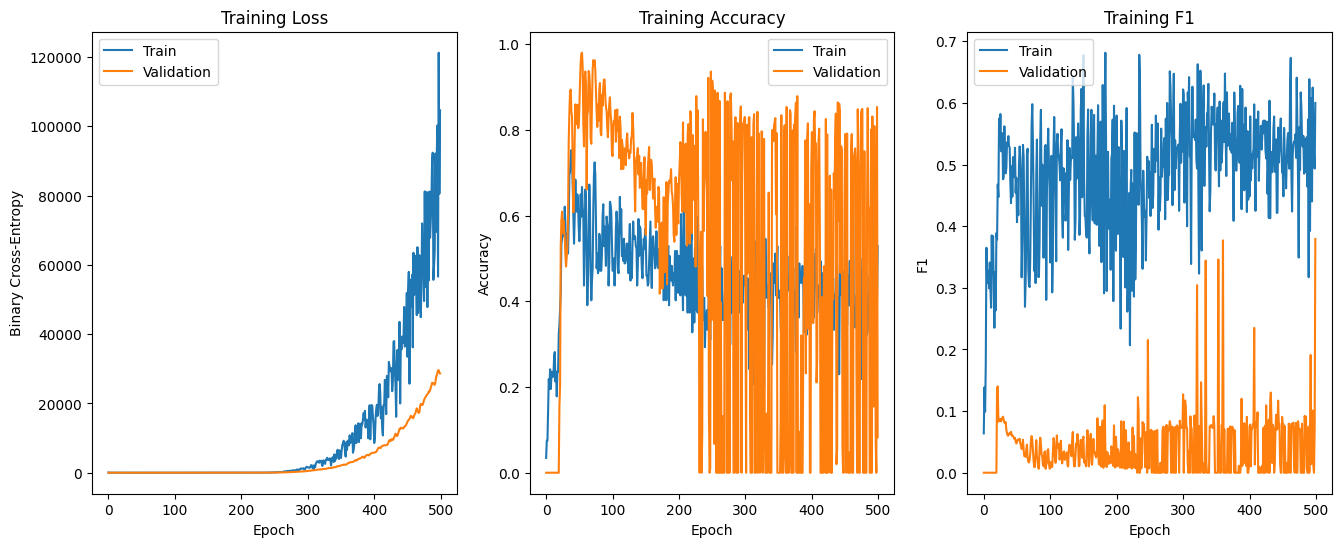

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Binary Cross-Entropy")
axes[0].legend(["Train", "Validation"])

axes[1].plot(history.history['accuracy'])
axes[1].plot(history.history['val_accuracy'])
axes[1].set_title("Training Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend(["Train", "Validation"])

axes[2].plot([f1s[0] for f1s in history.history['F1Score']])
axes[2].plot([f1s[0] for f1s in history.history['val_F1Score']])
axes[2].set_title("Training F1")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("F1")
axes[2].legend(["Train", "Validation"])